<a href="https://colab.research.google.com/github/supratim1121992/Object-Detection-with-Yolov5/blob/main/Grocery_YOLOv5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grocery Product Detection using Yolov5


* This notebook implements the widely popular Yolov5 model (released in June, 2020) on a dataset of Grocery products arranged in different shelves. The code was executed on Google Colab with free GPU instance and might need further changes to run locally or on a virtual environment.
* The notebook aims to serve as a quick starting point for anyone looking to try out the Yolov5 model and does not implement more advanced steps such as hyperparameter optimisation, intensive data pre-processing etc. Further the hyperparameters used for training are for a baseline model (due to limitations on processing and computation on Colab) and will need more exhaustive training for optimal performance on test images.
* The object detection results can be further used for various analyses with downstream post-processing steps not included in the notebook.
* Refer to Ultralytics' GitHub repository for more details on the Yolov5 family of models like tutorials, model architectures and tips to improve training results.
> https://github.com/ultralytics/yolov5
>
* For more details on the dataset and annotations used, refer to the following link:
> https://github.com/gulvarol/grocerydataset
>
* The following links can serve as additional references:
> * https://github.com/ultralytics/yolov5
> * https://blog.paperspace.com/train-yolov5-custom-data/
> * https://towardsdatascience.com/how-to-train-a-custom-object-detection-model-with-yolo-v5-917e9ce13208#:~:text=YOLOv5%20is%20a%20recent%20release,in%20a%20framework%20called%20Darknet.
> * https://towardsdatascience.com/advanced-yolov5-tutorial-enhancing-yolov5-with-weighted-boxes-fusion-3bead5b71688

### Installations and Loading


In [ ]:
!git clone https://github.com/ultralytics/yolov5
!pip install -r yolov5/requirements.txt 
!pip install -U albumentations

In [2]:
import os, random, numpy as np, pandas as pd, shutil, matplotlib.pyplot as plt, yaml
from tqdm import tqdm
from PIL import Image, ImageDraw
from sklearn.model_selection import train_test_split

### Data Download and File Management
*   Create directories and arrange files.
*   Download public grocery dataset along with annotations.
*   Remove unwanted files and folders.



In [ ]:
!mkdir Grocery_Dataset
%cd Grocery_Dataset
!wget -q https://storage.googleapis.com/open_source_datasets/ShelfImages.tar.gz
!tar xf ShelfImages.tar.gz
!wget -q https://github.com/gulvarol/grocerydataset/releases/download/1.0/GroceryDataset_part2.tar.gz
!tar xf GroceryDataset_part2.tar.gz
cols = ["image_name","x_min","y_min","x_max","y_max","class_id"]
master_df = pd.read_csv("https://raw.githubusercontent.com/gulvarol/grocerydataset/master/annotations.csv", 
                        names = cols)

In [4]:
!mkdir images annotations
!mv ShelfImages/train/*.JPG images
!mv ShelfImages/test/*.JPG images
shutil.rmtree("ShelfImages",ignore_errors = True)
!rm ShelfImages.tar.gz

### Training Data Expansion
> This section adds additional data to the publicly available Grocery Dataset by using cropped images of the individual products from the original dataset. This is to aid in model training by having additional training records since the original dataset only has 354 images. <br>
**NOTE:** Cropped images for the "Others" class (class 0) are not added to the original data to prevent further class imbalance as the class is already over-represented.
>
* Create explicit function to:
  * Rename cropped images and convert them to JPG format.
  * Move images to the folder containing the original images.
  * Assign annotations for cropped images.
* Append annotation data for cropped images to the original annotations.
* Remove unwanted files and folders.




In [ ]:
def create_antt_data(cls):
  if cls != "0":
    img_src = os.path.join("ProductImagesFromShelves",cls)
    ls_img = os.listdir(img_src)
    ls_antt = []
    for img in tqdm(ls_img):
      img_fl = Image.open(os.path.join(img_src,img))
      img_nm = img.replace(".JPG_","_")
      img_fl.save(os.path.join("images",img_nm.replace(".png",".JPG")))
      ls_antt.append({"image_name": img_nm.replace(".png",".JPG"),"x_min": 0,"y_min": 0,
                      "x_max": img_fl.size[0],"y_max": img_fl.size[1],"class_id": int(cls)})
    return pd.DataFrame(ls_antt)
  
  else:
    
    return None

df_antt = pd.concat([master_df,pd.concat(list(map(create_antt_data,os.listdir("ProductImagesFromShelves"))),ignore_index = True)],ignore_index = True,copy = True)
shutil.rmtree("BrandImagesFromShelves",ignore_errors = True)
shutil.rmtree("ProductImagesFromShelves",ignore_errors = True)
!rm GroceryDataset_part2.tar.gz

### Annotation Reformatting and Testing
> The original annotation file (CSV format) cannot be used with the Yolov5 model and thereby needs to be modified for compatibility. Refer the following link for details on the expected annotation format for Yolov5:
> * https://github.com/ultralytics/yolov5/issues/7586  

In [ ]:
for img in tqdm(os.listdir("images")):
  ls_bbox = df_antt.loc[df_antt.image_name == img].drop("image_name",axis = 1).apply(lambda x: x.to_dict(),axis = 1).to_list()
  img_dim = Image.open(os.path.join("images",img)).size
  ls_out = []

  for bbox in ls_bbox:
    bbox_x = (bbox["x_min"] + bbox["x_max"]) / (2 * img_dim[0])
    bbox_y = (bbox["y_min"] + bbox["y_max"]) / (2 * img_dim[1])
    bbox_w = (bbox["x_max"] - bbox["x_min"]) / img_dim[0]
    bbox_h = (bbox["y_max"] - bbox["y_min"]) / img_dim[1]
    class_id = bbox["class_id"]
    ls_out.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id,bbox_x,bbox_y,bbox_w,bbox_h))

  fl_nm = os.path.join("annotations",img.replace("JPG","txt"))
  print("\n".join(ls_out),file = open(fl_nm,"w"))

* Provide class label mapping.

In [7]:
antt_path = [os.path.join('annotations',x) for x in os.listdir('annotations') if x[-3:] == "txt"]
antt_path.sort()
cls_map = {0: "Other",1: "Marlboro",2: "Kent",3: "Camel",4: "Parliament",5: "Pall Mall",
           6: "Monte Carlo",7: "Winston",8: "Lucky Strike",9: "2001",10: "Lark"}

* Create explicit function to:
 * Revert Yolov5 annotations to original state.
 * Plot bounding boxes and class labels.
* Test Yolov5 compatible annotations on random images.

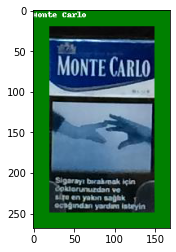

In [8]:
def plot_bbox(image,annotation_list,class_id_to_name_mapping):
  annotations = np.array(annotation_list)
  w,h = image.size
    
  plotted_image = ImageDraw.Draw(image)

  transformed_annotations = np.copy(annotations)
  transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
  transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
  transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
  transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
  transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
  transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
  for ann in transformed_annotations:
    obj_cls, x0, y0, x1, y1 = ann
    plotted_image.rectangle(((x0,y0),(x1,y1)),outline = "green",width = 20)
        
    plotted_image.text((x0,y0),class_id_to_name_mapping[(int(obj_cls))])
    
  plt.imshow(np.array(image))
  plt.show()

antt_tst = random.choice(antt_path)
with open(antt_tst,"r") as file:
  ls_antt_tst = file.read().split("\n")[:-1]
  ls_antt_tst = [x.split(" ") for x in ls_antt_tst]
  ls_antt_tst = [[float(y) for y in x ] for x in ls_antt_tst]

img_tst_path = antt_tst.replace("annotations","images").replace("txt","JPG")
img_tst = Image.open(img_tst_path)
plot_bbox(img_tst,ls_antt_tst,cls_map)

### Data Partitioning and Model Training

* Split the entire data into train (80%), validation (10%) and test sets (10%).

In [ ]:
img_path = [os.path.join("images",x) for x in os.listdir("images")]
img_path.sort()

trn_img_path,val_img_path,trn_antt_path,val_antt_path = train_test_split(img_path,antt_path,test_size = 0.2,random_state = 666)
val_img_path,tst_img_path,val_antt_path,tst_antt_path = train_test_split(val_img_path,val_antt_path,test_size = 0.5,random_state = 666)

!mkdir images/train images/val images/test annotations/train annotations/val annotations/test

def transfer_files(list_of_files,destination_folder):
  for f in list_of_files:
    try:
      shutil.move(f,destination_folder)
    except:
      print(f)
      assert False

transfer_files(trn_img_path,"images/train")
transfer_files(val_img_path,"images/val/")
transfer_files(tst_img_path,"images/test/")
transfer_files(trn_antt_path,"annotations/train/")
transfer_files(val_antt_path,"annotations/val/")
transfer_files(tst_antt_path,"annotations/test/")

!mv annotations labels
%cd /content/yolov5   

* Create and save the model configuration file with training parameters.

In [10]:
cls_lab = list(cls_map.values())
data = {"train": "/content/Grocery_Dataset/images/train","val": "/content/Grocery_Dataset/images/val",
        "test": "/content/Grocery_Dataset/images/train","nc": len(cls_lab),"names": cls_lab}
with open("/content/yolov5/grocery_data.yaml","w") as out_fl:
 yaml.dump(data,out_fl,default_flow_style = False)

* Train the model (Yolov5l version) with default hyperparameters.

> * The Yolov5 model is available in multiple versions, each with varying complexity and number of trained parameters. Refer to https://github.com/ultralytics/yolov5/releases for details on each version and their performance results on the COCO dataset.
* The training process implemented here includes augmentation methods available in the Albumentations library with pretrained weights for initiation.
* Training on systems with limitations on computation (such as free Colab instance) might require the image and/or batch sizes to be reduced to avoid any runtime errors. <br>
https://github.com/ultralytics/yolov5/issues/5720
* Refer to the following links for further details on setting up custom model hyperparameters, methods for hyperparameter optimisation using Genetic Algorithm and augmentation methods available with Albumentations: <br>
 * https://github.com/ultralytics/yolov5/discussions/7319
 * https://github.com/ultralytics/yolov5/issues/607
 * https://albumentations.ai/docs/api_reference/augmentations/transforms/

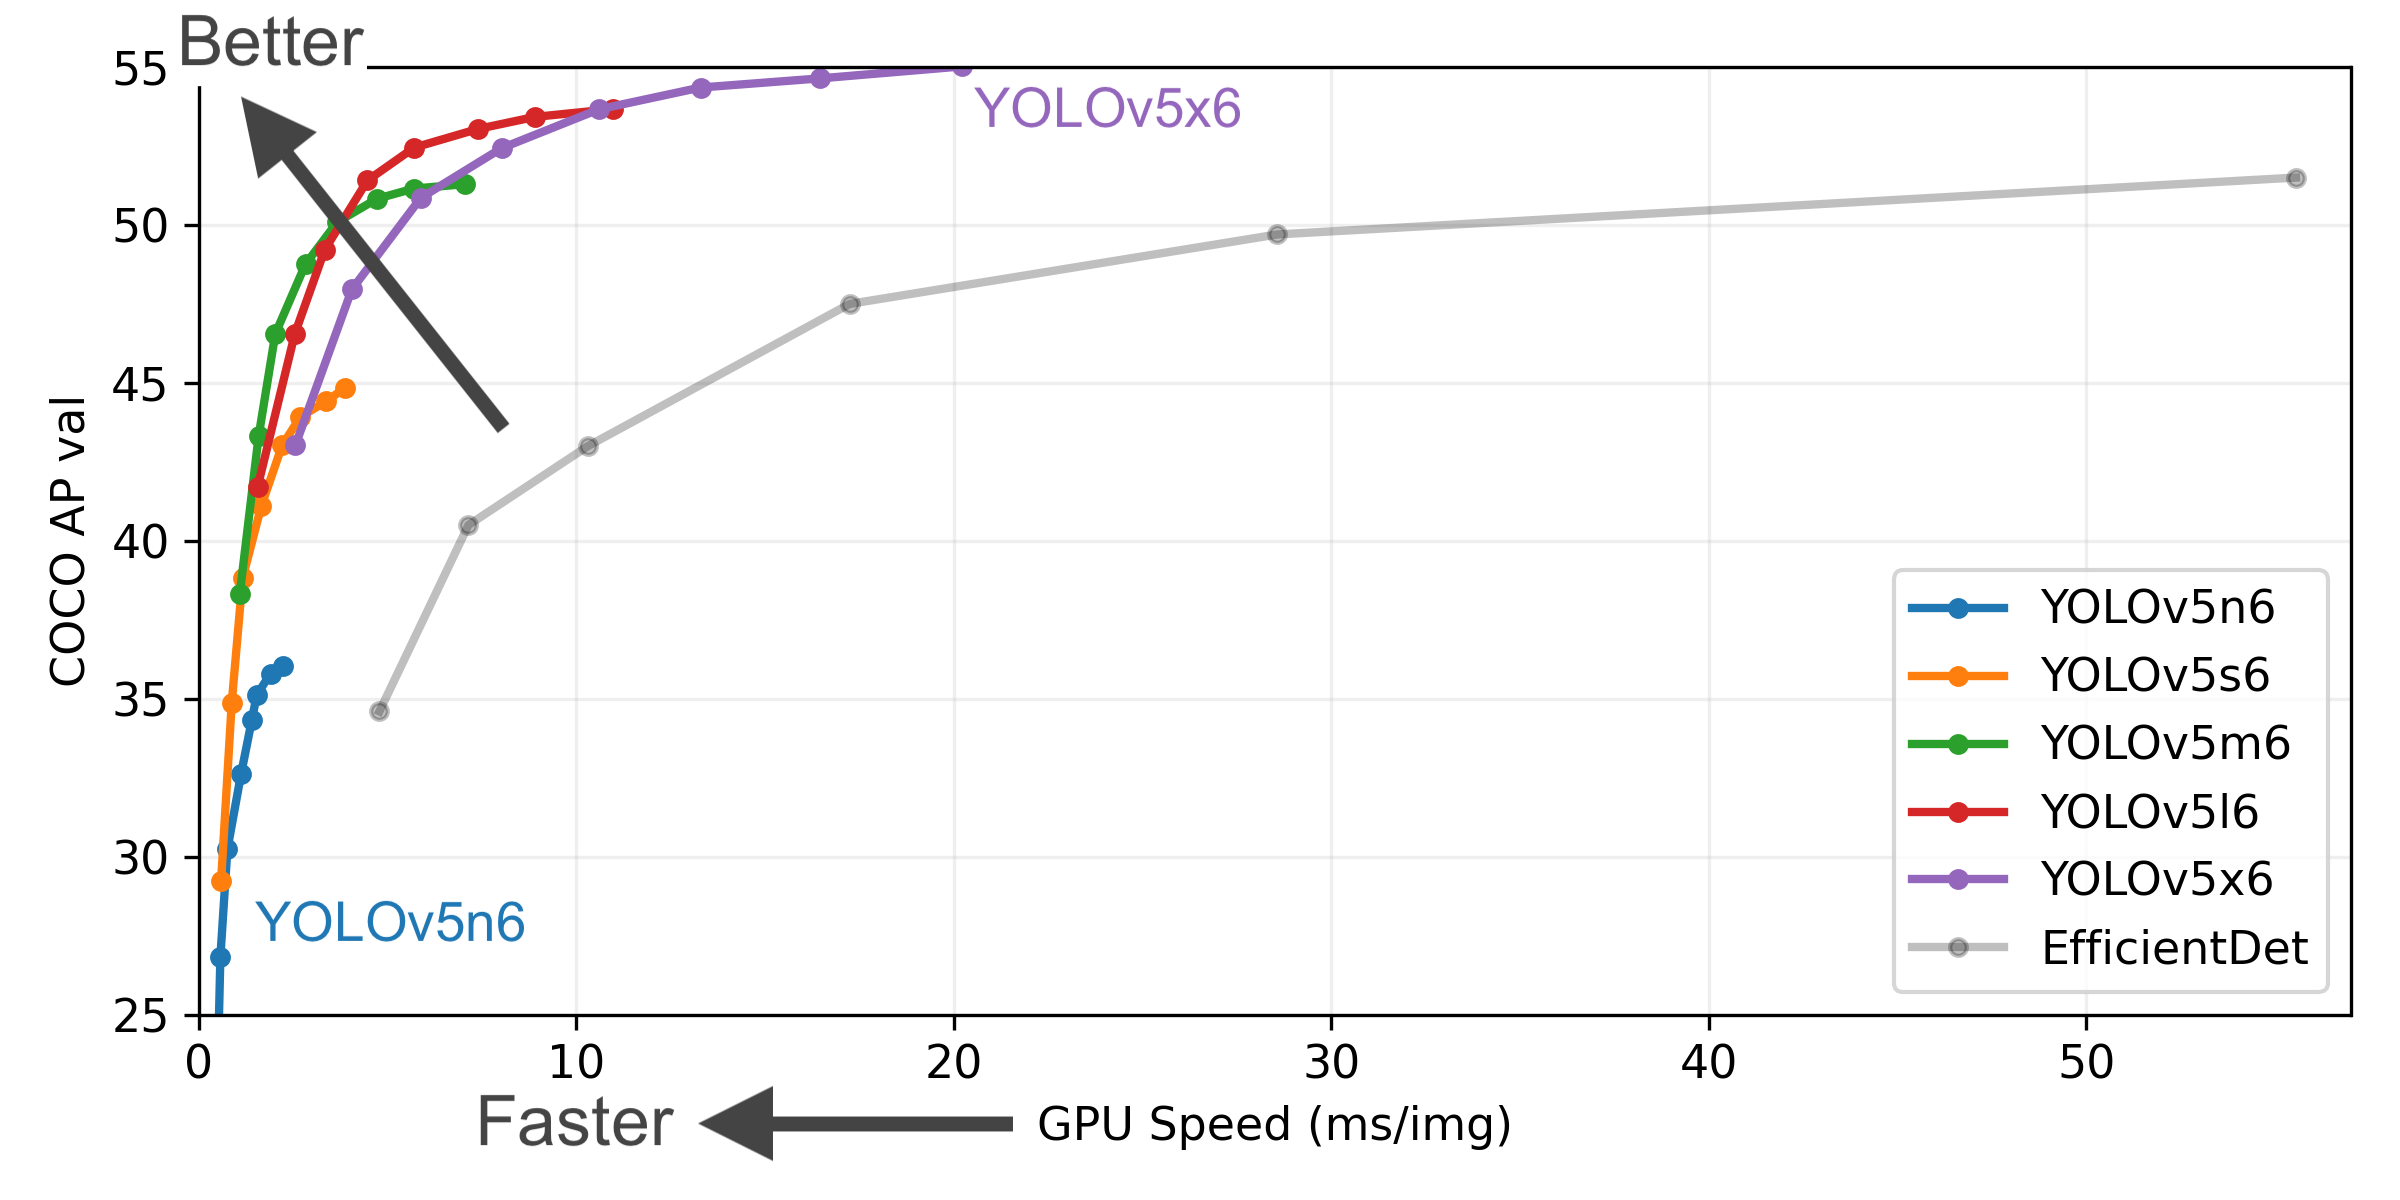



In [ ]:
!python train.py --img 320 --cfg yolov5l.yaml --batch 8 --epochs 100 --data grocery_data.yaml --weights yolov5l.pt --name grocery_detection

### Inference on Test Images

* Run inference with the following flags:
 * *source* : Path to the directory containing the test images
> Inference can also be run on single images, videos, webcam feed or streams.
 * *weights* : Weights of the trained model to be used for inference.
 * *conf* : Objectness confidence threshold. 
> The confidence value can be tuned to reduce False Positives or compensate for missed detections as required.
 * *name* : Directory to use for storing the run detections.
> The outputs from inference can be found in /yolov5/runs/detect/grocery_detection in this case.




* Plot random output image to verify detection results.

In [ ]:
tst_out_dir = "runs/detect/grocery_detection/"
tst_out = [os.path.join(tst_out_dir,x) for x in os.listdir(tst_out_dir)]
tst_out_img = Image.open(random.choice(tst_out))
plt.imshow(np.array(tst_out_img))

* Compute evaluation metrics on test set with the following flags:
 * *weights* : Weights of the trained model to be evaluated.
 * *data* : Model configuration file (YAML) created and saved earlier.
 * *task* : Task to be performed ("test" in this case).
 * *name* : Directory to use for saving the evaluation results.
> Additional plots for evaluation can be found in /yolov5/runs/detect/grocery_detection.

In [ ]:
!python val.py --weights runs/train/grocery_detection/weights/best.pt --data grocery_data.yaml --task test --name grocery_detection_results